In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import functions
import pytket

from lambeq import BobcatParser

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [6]:
## IMDB set

## Process data, split into training/test
imdb_data = pd.read_csv('IMDB Dataset.csv')
## My PC is weak as fuck so truncate Dataset
imdb_data = imdb_data[1:1000]
size = int(len(imdb_data)*0.8)
imdb_training = imdb_data.loc[:size].copy()
imdb_testing = imdb_data.loc[size:].copy()

## convert to numpy array
train, trainlabels = imdb_training.iloc[:,0].to_numpy(), imdb_training.iloc[:,1].to_numpy()
test, testlabels = imdb_testing.iloc[:,0].to_numpy(), imdb_testing.iloc[:,1].to_numpy()


In [7]:
## Twitter dataset
negative = np.loadtxt("processedNegative.csv", delimiter=",", dtype = str).reshape(-1,1)
neglabels = np.full(np.shape(negative),-1)
neutral = np.loadtxt("processedNeutral.csv", delimiter=",", dtype = str).reshape(-1,1)
neutlabels = np.full(np.shape(neutral),0)
positive = np.loadtxt("processedPositive.csv", delimiter=",", dtype = str).reshape(-1,1)
poslabels = np.full(np.shape(positive),1)

negset = np.concatenate((negative,neglabels), axis=1)
neutset = np.concatenate((neutral,neutlabels), axis=1)
posset =  np.concatenate((positive,poslabels), axis=1)

dataset = np.concatenate((negset,neutset,posset), axis=0)

np.random.shuffle(dataset)
print(len(dataset))

3873


In [8]:
sentences = [] 
labels =[]
for i in dataset:
    sentences.append(i[0])
    labels.append(i[1])

ratio = 0.8
size = int(len(dataset)*ratio)
train_data, train_labels = sentences[1:10], labels[1:10]
val_data, val_labels = sentences[1:10], labels[1:10]
train_data


["Thanks by has  notice of me Greetings : JossetteD'Hermanni",
 'Supreme Court is told that people not being allowed to deposit notes till Mar31 as promised',
 'Nice gif happy',
 "i can't continue this right now because the lighting is shitty as f i swear sorry sad ",
 ' virulent and more. Also in epaper. ',
 "damn that's unfortunate for them unhappy ",
 'My salary reminds me of the weekends',
 ' thanks for your articles. B',
 'U.S. Attorney Preet Bharara is fired after refusing to quit. More here: ']

In [4]:
## Convert sentences to circuits w lambeq
parser = BobcatParser(root_cats=('NP','N'),verbose = 'text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

NameError: name 'train_data' is not defined

In [6]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

In [10]:
from lambeq import AtomicType, IQPAnsatz, remove_cups
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
PUNC = AtomicType.PUNCTUATION
C = AtomicType.CONJUNCTION

ansatz = IQPAnsatz({N: 1,S: 0, P: 1, PUNC: 0, C: 0},
                   n_layers=2, n_single_qubit_params=2)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

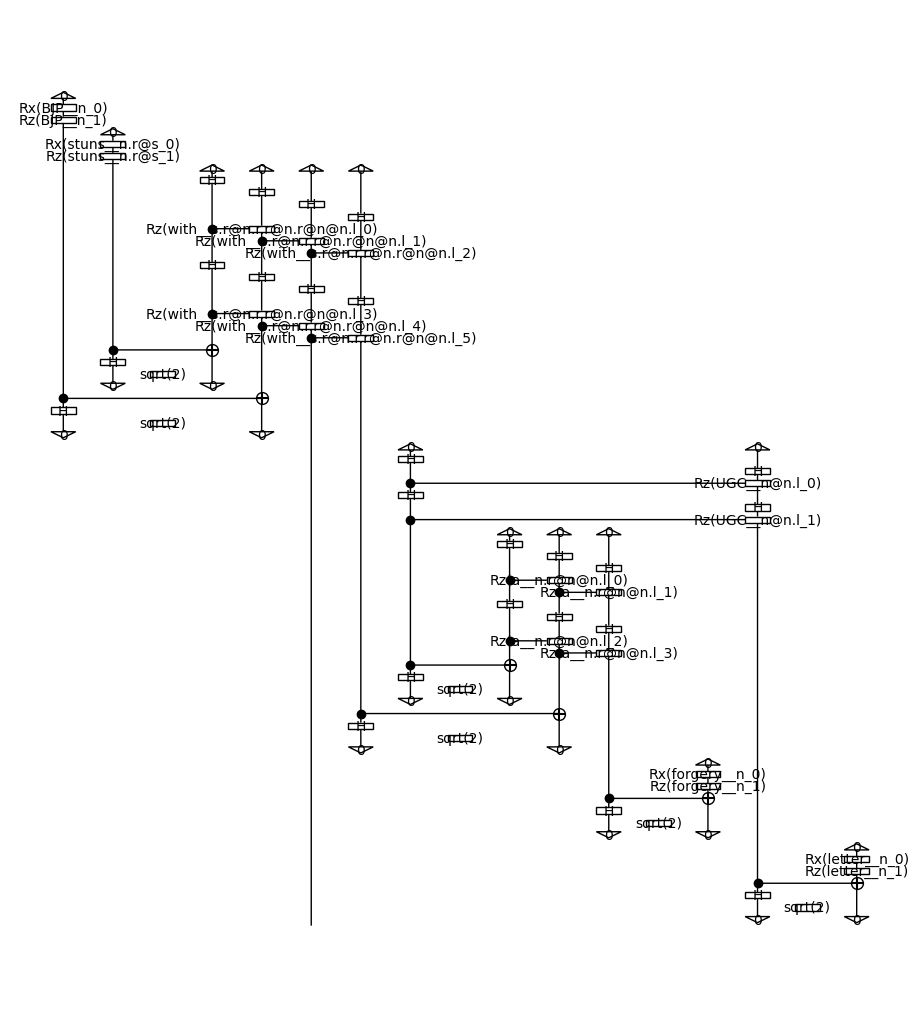

In [11]:
train_circuits[5].draw(figsize=(9, 10))

In [14]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)


ModuleNotFoundError: No module named 'pytket.extensions'